In [17]:
import pandas as pd
import torch
import numpy as np
from sklearn.model_selection import KFold
from sklearn.preprocessing import MinMaxScaler, StandardScaler 
from sklearn.metrics import r2_score
from gpytorch.mlls import ExactMarginalLogLikelihood
import gpytorch
import altair as alt
import matplotlib.pyplot as plt
import re
from scipy.stats import norm

UTILITY

In [18]:
def plot_gp_results(candidates, mean_np, std_np, ei_np, pi_np, iteration, label="target_value"):
    x = np.arange(len(candidates))  # Struktur-Index
    names = candidates["structure_name"].values

    fig, axs = plt.subplots(3, 1, figsize=(12, 10), sharex=True)
    plt.subplots_adjust(hspace=0.3)

    axs[0].plot(x, mean_np, color="C0", label="Predicted Mean")
    axs[0].fill_between(x, mean_np - std_np, mean_np + std_np, color="C0", alpha=0.3, label="Uncertainty (±1σ)")
    axs[0].set_ylabel("Predicted Mean")
    axs[0].set_title(f"Iteration {iteration}: GP Prediction (mean ± std)")
    axs[0].legend()
    axs[0].grid(alpha=0.3)

    axs[1].plot(x, ei_np, color="C1")
    axs[1].set_ylabel("Expected Improvement")
    axs[1].set_title("Expected Improvement over Candidates")
    axs[1].grid(alpha=0.3)

    axs[2].plot(x, pi_np, color="C2")
    axs[2].set_ylabel("Probability of Improvement")
    axs[2].set_xlabel("Candidate Structure Index")
    axs[2].set_title("Probability of Improvement")
    axs[2].grid(alpha=0.3)

    # Optional: Struktur-Namen als xticks (nur alle paar, sonst zu viele)
    if len(names) <= 30:
        axs[2].set_xticks(x)
        axs[2].set_xticklabels(names, rotation=90)
    else:
        step = max(1, len(names)//30)
        axs[2].set_xticks(x[::step])
        axs[2].set_xticklabels(names[::step], rotation=90)

    plt.tight_layout()
    plt.show()


In [19]:
def is_bin_column(col) -> bool:
    """
    True für:
      - 'bin_0', 'bin_1', ... (beliebige nichtnegative Integer)
      - auch für numerische Spaltennamen wie 0, 1, '0', '1' (optional nützlich)
    """
    # numerische Spaltennamen zulassen (z. B. 0, 1, 2)
    if isinstance(col, (int, np.integer)):
        return True

    s = str(col)
    if s.isdigit():                 # '0', '1', ...
        return True
    if re.fullmatch(r"bin_\d+", s): # 'bin_0', 'bin_1', ...
        return True
    return False

MODELL GP

In [20]:
class ExactGPModel(gpytorch.models.ExactGP):
    def __init__(self, train_x, train_y, likelihood):
        super(ExactGPModel, self).__init__(train_x, train_y, likelihood)
        self.mean_module = gpytorch.means.ConstantMean()
        self.covar_module = gpytorch.kernels.ScaleKernel(gpytorch.kernels.RBFKernel())

    def forward(self, x):
        mean_x = self.mean_module(x)
        covar_x = self.covar_module(x)
        return gpytorch.distributions.MultivariateNormal(mean_x, covar_x)

def train_gp(xt_train, yt_train, training_iterations=100):
    likelihood = gpytorch.likelihoods.GaussianLikelihood()
    model = ExactGPModel(xt_train, yt_train, likelihood)

    model.train()
    likelihood.train()

    optimizer = torch.optim.Adam(model.parameters(), lr=0.2)
    mll = ExactMarginalLogLikelihood(likelihood, model)

    losses = []

    for i in range(training_iterations):
        optimizer.zero_grad()
        output = model(xt_train)
        loss = -mll(output, yt_train)
        losses.append(loss.item())
        loss.backward()
        optimizer.step()

    return model.eval(), likelihood.eval(), losses

DATEN EINLESEN & FILTERN

In [ ]:
dft_data = pd.read_csv("/Users/danielbock/MASTERTHESIS/MASTA/DataArchiv/DFT_Data_clean_06_10.csv")
expV_data = pd.read_csv("/Users/danielbock/MASTERTHESIS/MASTA/DataArchiv/Vext_allcsv/Vext_allTEMP_32grid_50b_exp.csv")
data = pd.merge(dft_data, expV_data, 'inner', on=["structure_name", "temperature_kelvin"])
feature_columns = [col for col in data.columns if is_bin_column(col)]
data = data[data.beladung_mol_per_kg > 0]
data = data[(data.temperature_kelvin == 400) & (data.pressure_bar == 0.1)]

# data.shape

FEATURES/LABEL CUSTOM

In [22]:
data["beladung_pro_vol"] = data["beladung_atoms"] / data["volume_kubAng"]

data[feature_columns] = (
    data[feature_columns]
    .multiply(data["grid.dv"], axis=0)
    .div(data["volume_kubAng"], axis=0)
)

#additional_features = [""] #["density_bulk", "pressure_bar", "temperature_kelvin"]
#feature_columns = feature_columns + additional_features
#feature_columns


NORMALIZE

In [23]:
normalize_feature = True
normalize_labels = True

FOLD - TRAINING - PREDICTION

In [24]:
kf = KFold(n_splits=10, shuffle=True, random_state=42)

label = "beladung_pro_vol"
X = data[feature_columns].values 
y = data[label].values 

ids = data.index.values

split_info = []

for fold, (train_idx, test_idx) in enumerate(kf.split(X), start=1):
    x_train = torch.tensor(X[train_idx], dtype=torch.float64)
    y_train = torch.tensor(y[train_idx], dtype=torch.float64)
    x_test = torch.tensor(X[test_idx], dtype=torch.float64)
    y_test = torch.tensor(y[test_idx], dtype=torch.float64)

    train_ids = ids[train_idx]
    test_ids = ids[test_idx]

    test_df = data.iloc[test_idx].copy()
    test_df["fold"] = fold

    if normalize_feature:
        feature_transformer = MinMaxScaler()
        feature_transformer.fit(x_train)
        xt_train = torch.tensor(feature_transformer.transform(x_train), dtype=torch.float64)
        xt_test = torch.tensor(feature_transformer.transform(x_test), dtype=torch.float64) #*2
    else:
        xt_train = x_train
        xt_test = x_test

    # Label-Normalisierung
    if normalize_labels:
        label_transformer = MinMaxScaler()  # oder StandardScaler()
        label_transformer.fit(y_train.unsqueeze(1))
        yt_train = torch.tensor(label_transformer.transform(y_train.unsqueeze(1)).flatten(), dtype=torch.float64)
        yt_test = torch.tensor(label_transformer.transform(y_test.unsqueeze(1)).flatten(), dtype=torch.float64)
    else:
        yt_train = y_train
        yt_test = y_test

    # Training
    model, likelihood, losses = train_gp(xt_train, yt_train, training_iterations=200)

    # Prediction
    with torch.no_grad():
        prediction = model(xt_test)
        inverse_transformed_prediction = label_transformer.inverse_transform(
            prediction.mean.unsqueeze(1)
        ).squeeze()
        inverse_transformed_prediction = np.where(
            inverse_transformed_prediction > 0, inverse_transformed_prediction, 0
        )

    # Ergebnisse
    test_df[f"{label}_pred"] = inverse_transformed_prediction
    test_df["abs_rel_deviation"] = np.abs(
        (test_df[label] - test_df[f"{label}_pred"]) / test_df[label] * 100
    )

    split_info.append(test_df)

results = pd.concat(split_info, ignore_index=True)
results
# results.to_csv("GP_results_beladung_pro_vol_400K_0.1bar_customFeatures.csv", index=False)

,structure_name,pressure_bar,temperature_kelvin,volume_kubAng,grid.dv,density_Atmos_per_kubAng,density_bulk,fraction_of_used_points,beladung_mol_per_kg,beladung_atoms,...,bin_46,bin_47,bin_48,bin_49,x_max,x_min,beladung_pro_vol,fold,beladung_pro_vol_pred,abs_rel_deviation
0,OFF,0.1,400.0,1117.957819,0.004265,13.171425,0.000002,0.123833,0.049037,0.056172,...,0.0,0.0,0.0,0.0,22026.465795,0.0,0.000050,1,0.000038,23.615042
1,PWO,0.1,400.0,1165.326305,0.004445,7.972067,0.000002,0.092529,0.029491,0.035439,...,0.0,0.0,0.0,0.0,22026.465795,0.0,0.000030,1,0.000034,11.829317
2,CDO,0.1,400.0,1994.011066,0.007607,9.644143,0.000002,0.053528,0.033915,0.073359,...,0.0,0.0,0.0,0.0,22026.465795,0.0,0.000037,1,0.000038,3.076055
3,STF,0.1,400.0,1896.240805,0.007234,6.242236,0.000002,0.129852,0.023485,0.045154,...,0.0,0.0,0.0,0.0,22026.465795,0.0,0.000024,1,0.000016,34.524755
4,ZJN,0.1,400.0,3505.954803,0.013374,13.079626,0.000002,0.075485,0.048524,0.174929,...,0.0,0.0,0.0,0.0,22026.465795,0.0,0.000050,1,0.000048,4.761885
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
240,SSY,0.1,400.0,1659.354779,0.006330,3.108884,0.000002,0.112091,0.011697,0.019679,...,0.0,0.0,0.0,0.0,22026.465795,0.0,0.000012,10,0.000012,2.661982
241,GME,0.1,400.0,1594.523637,0.006083,5.146318,0.000002,0.140869,0.021708,0.031303,...,0.0,0.0,0.0,0.0,22026.465795,0.0,0.000020,10,0.000018,9.269410
242,AEI,0.1,400.0,3189.362594,0.012166,6.145461,0.000002,0.141479,0.025925,0.074768,...,0.0,0.0,0.0,0.0,22026.465795,0.0,0.000023,10,0.000012,50.758345
243,GON,0.1,400.0,1691.906700,0.006454,4.858097,0.000002,0.067993,0.016308,0.031355,...,0.0,0.0,0.0,0.0,22026.465795,0.0,0.000019,10,0.000016,14.499676


ALLE DATEN

In [25]:
print(f"R²                        : {r2_score(results[label], results[f'{label}_pred']):.4f}")
print(f"Median APE                : {results['abs_rel_deviation'].median():.2f}%")
print(f"Mean APE                  : {results['abs_rel_deviation'].mean():.2f}%")
print(f"Final Loss                : {losses[-1]:.4f}")

count = (results['abs_rel_deviation'] > 20).sum()
print(f"Abs rel dev > 20%         : {count} out of {len(results)}")
print(f"Max abs rel dev           : {results['abs_rel_deviation'].max():.2f}%")


R²                        : 0.8911
Median APE                : 18.63%
Mean APE                  : 127310.09%
Final Loss                : -1.8757
Abs rel dev > 20%         : 115 out of 245
Max abs rel dev           : 14951548.20%


EINZELNE FOLDS

In [26]:
for fold, group in results.groupby("fold"):
    print(f"\nFold {fold}")
    print(f"R²           : {r2_score(group[label], group[f'{label}_pred']):.4f}")
    print(f"Median APE   : {group['abs_rel_deviation'].median():.2f}%")
    print(f"Mean APE     : {group['abs_rel_deviation'].mean():.2f}%")
    print(f"Max ARD      : {group['abs_rel_deviation'].max():.2f}%")
    print(f"Final Loss   : {losses[-1]:.4f}")



Fold 1
R²           : 0.9598
Median APE   : 18.30%
Mean APE     : 33.52%
Max ARD      : 292.86%
Final Loss   : -1.8757

Fold 2
R²           : 0.6866
Median APE   : 17.63%
Mean APE     : 1009.35%
Max ARD      : 22233.61%
Final Loss   : -1.8757

Fold 3
R²           : 0.8738
Median APE   : 12.64%
Mean APE     : 38.23%
Max ARD      : 351.30%
Final Loss   : -1.8757

Fold 4
R²           : 0.7251
Median APE   : 19.87%
Mean APE     : 142.30%
Max ARD      : 2500.67%
Final Loss   : -1.8757

Fold 5
R²           : 0.9118
Median APE   : 20.66%
Mean APE     : 96214.24%
Max ARD      : 2404768.24%
Final Loss   : -1.8757

Fold 6
R²           : 0.7666
Median APE   : 25.18%
Mean APE     : 223.33%
Max ARD      : 3286.68%
Final Loss   : -1.8757

Fold 7
R²           : 0.9469
Median APE   : 15.28%
Mean APE     : 40.74%
Max ARD      : 483.27%
Final Loss   : -1.8757

Fold 8
R²           : 0.9032
Median APE   : 20.71%
Mean APE     : 59.24%
Max ARD      : 925.13%
Final Loss   : -1.8757

Fold 9
R²           : 0.

PARITY PLOT - ALT

In [27]:
alt.Chart(results).mark_circle(size=60).encode(
    x=label,
    y=f"{label}_pred",
    color="fold:N",
    tooltip=["structure_name", label, f"{label}_pred", "abs_rel_deviation", "fold"]
).interactive()

alt.Chart(...)

In [28]:
alt.Chart(results[results["fold"] == 1]).mark_circle(size=60).encode(
    x=label,
    y=f"{label}_pred",
    color="fold:N",
    tooltip=["structure_name", label, f"{label}_pred", "abs_rel_deviation", "fold"]
).interactive()


alt.Chart(...)

DATA ANALYSIS

In [29]:
high_dev_names = results.loc[results["abs_rel_deviation"] > 20, "structure_name"].tolist()
filtered_results = results[results["structure_name"].isin(high_dev_names)]
filtered_results

filter_res = results.sort_values(by="beladung_mol_per_kg", ascending=False)

filter_res.head()

,structure_name,pressure_bar,temperature_kelvin,volume_kubAng,grid.dv,density_Atmos_per_kubAng,density_bulk,fraction_of_used_points,beladung_mol_per_kg,beladung_atoms,...,bin_46,bin_47,bin_48,bin_49,x_max,x_min,beladung_pro_vol,fold,beladung_pro_vol_pred,abs_rel_deviation
155,DOH,0.1,400.0,2005.189845,0.007649,51.476098,0.000002,0.083206,0.178059,0.393751,...,0.0,0.000015,0.0,0.0,22026.465795,0.0,0.000196,7,0.000161,18.080163
238,LOS,0.1,400.0,1423.228645,0.005429,50.890422,0.000002,0.075287,0.172469,0.276294,...,0.0,0.000000,0.0,0.0,22026.465795,0.0,0.000194,10,0.000188,3.396989
8,MTN,0.1,400.0,7919.869039,0.030212,43.341693,0.000002,0.075317,0.160247,1.309435,...,0.0,0.000000,0.0,0.0,22026.465795,0.0,0.000165,1,0.000182,9.980336
161,MEP,0.1,400.0,2574.169378,0.009820,38.941898,0.000002,0.056030,0.138357,0.382397,...,0.0,0.000000,0.0,0.0,22026.465795,0.0,0.000149,7,0.000126,14.908223
129,MAR,0.1,400.0,4052.020576,0.015457,30.674092,0.000002,0.062744,0.104944,0.474137,...,0.0,0.000000,0.0,0.0,22026.465795,0.0,0.000117,6,0.000140,19.514181


BAYESIAN OPTIMIZATION

In [30]:
from torch.distributions import Normal

def af_log_expIm(mean, var, best_f, xi=0.01):
    """Logarithmic Expected Improvement acquisition function."""

    std = torch.sqrt(var)
    std_safe = torch.clamp(std, min=1e-9)  # Avoid division by zero
    z = (mean - best_f - xi) / std_safe
    normal = Normal(torch.zeros_like(z), torch.ones_like(z))
    cdf = normal.cdf(z)
    pdf = torch.exp(normal.log_prob(z))

    ei = std * (z * cdf + pdf)

    ei_safe = torch.clamp(ei, min=1e-9)  # Avoid log(0)
    log_ei = torch.log(ei_safe)
    return log_ei
    


Initial training points:
  Index 806, Structure LIT, beladung_pro_vol: 0.0000
Iteration: 0, Current Best: 8.22e-11
Iteration: 1, Current Best: 1.11e-04
Iteration: 2, Current Best: 1.11e-04
Iteration: 3, Current Best: 1.11e-04
Iteration: 4, Current Best: 1.11e-04
Iteration: 5, Current Best: 1.11e-04
Iteration: 6, Current Best: 1.11e-04
Iteration: 7, Current Best: 1.11e-04
Iteration: 8, Current Best: 1.11e-04
Iteration: 9, Current Best: 1.49e-04
Iteration: 10, Current Best: 1.94e-04
Iteration: 11, Current Best: 1.94e-04
Iteration: 12, Current Best: 1.96e-04
Iteration: 13, Current Best: 1.96e-04
Iteration: 14, Current Best: 1.96e-04
Iteration: 15, Current Best: 1.96e-04
Iteration: 16, Current Best: 1.96e-04
Iteration: 17, Current Best: 1.96e-04
Iteration: 18, Current Best: 1.96e-04
Iteration: 19, Current Best: 1.96e-04
Iteration: 20, Current Best: 1.96e-04
Iteration: 21, Current Best: 1.96e-04
Early stopping at iteration 22 due to no improvement in the last 10 iterations.
Best Value after

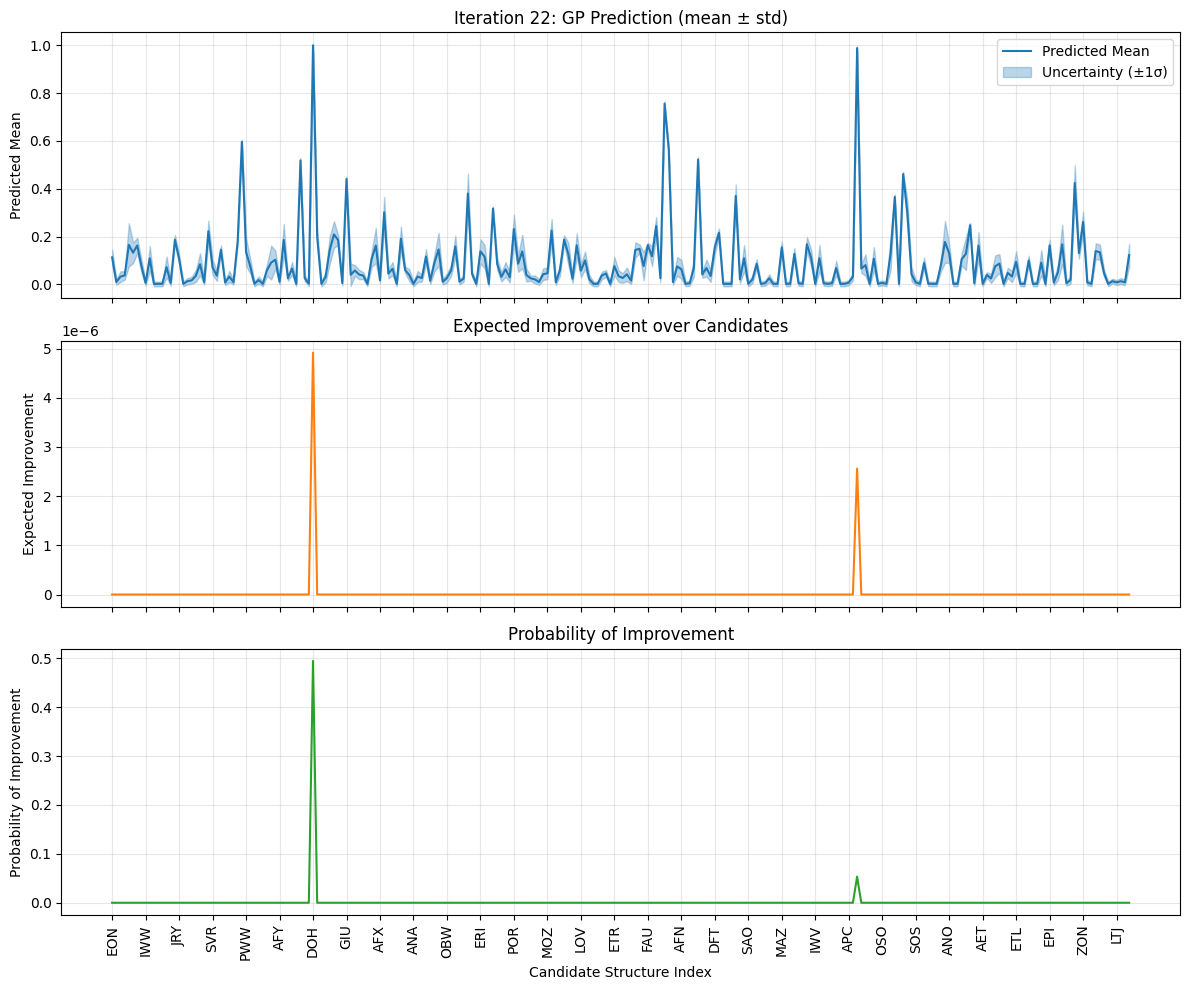

In [31]:
candidates = data.copy() # zunächst gefilteret, später alle Daten

patience = 10

n_initial = 1 # Anzahl der initialen Trainingspunkte
initial_indices = candidates.nsmallest(n_initial, label).index # hier geht auch random

print(f"Initial training points:")
for idx in initial_indices:
    print(f"  Index {idx}, Structure {candidates.loc[idx, 'structure_name']}, {label}: {candidates.loc[idx, label]:.4f}")

# Transfer from candidates to selection
selected = candidates.loc[initial_indices]
candidates = candidates.drop(initial_indices)
best = [selected[label].max()]

for i in range(100):
    if len(best) >= patience:
        if len(np.unique(best[-patience:])) == 1:
            print(f"Early stopping at iteration {i} due to no improvement in the last {patience} iterations.")
            break
    
    feature_transoformer = MinMaxScaler()
    label_transformer = MinMaxScaler()

    train_x = torch.tensor(feature_transoformer.fit_transform(selected[feature_columns].values))
    train_y = torch.tensor(label_transformer.fit_transform(selected[[label]].values)).flatten()

    test_x = torch.tensor(feature_transoformer.transform(candidates[feature_columns].values))

    model, likelihood, _ = train_gp(train_x, train_y, 250)
    with torch.no_grad():
        prediction = model(test_x)
        mean, var = prediction.mean, prediction.variance
    
    best_f = train_y.max()

    log_ei = af_log_expIm(mean, var, best_f, 0.01 * best_f)

    # Select the candidate with the highest acquisition value
    index = torch.argmax(log_ei).item()
    best.append(selected[label].max())
    print(f"Iteration: {i}, Current Best: {selected[label].max():.2e}")
    selected = pd.concat([selected, candidates.iloc[[index]]])
    canidates = candidates.drop(candidates.index[index])

print(f"Best Value after {len(best)} iterations: {best[-1]}")

mean_np = mean.detach().cpu().numpy().flatten()
var_np = var.detach().cpu().numpy().flatten()
std_np = np.sqrt(var_np)
ei_np = torch.exp(log_ei).detach().cpu().numpy().flatten()

# --- Probability of Improvement ---
best_f = train_y.max().item()
z = (mean_np - best_f) / std_np
pi_np = norm.cdf(z)


# --- Plot am Ende ---
plot_gp_results(candidates, mean_np, std_np, ei_np, pi_np, iteration=i, label=label)
    

Text(0.5, 0, 'Iterations')

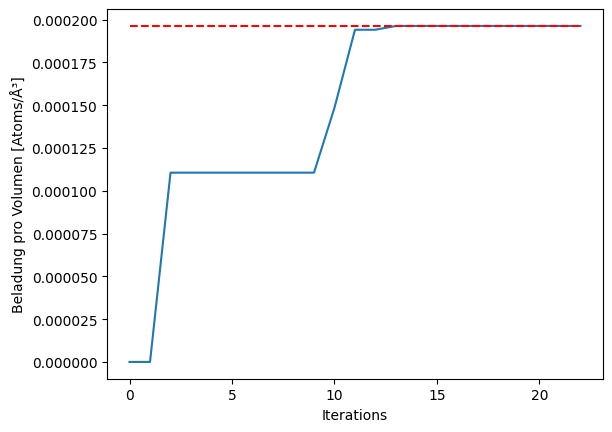

In [32]:
plt.plot(best)
plt.hlines(data[label].max(), 0, len(best)-1, colors='r', linestyles='dashed')
plt.ylabel("Beladung pro Volumen [Atoms/Å³]")
plt.xlabel("Iterations")